IMDB project idea is to take Top 10 highly paid actors of 2019(Forbes) and to create a movie distance graph for them. The logic is the following: we start with some actors pair. Get top N last movies for one actor, get top M actors from those movies and check if the second actor from the pair is in the obtained actors list. We also save movies checked and compare them. Moreover, we do our BFS-based search from both sides and check movies in batches. Number of top movies and actors is adviced to be restricted to improve the time performance.<br><br>
The rules are:
  - Distance is how many movies are between 2 actors.
  - If 2 actors starred in the same movie, movie distance is 1.
  - Only films are eligible (no TV shows, soap operas, etc.)
  - Only films where actor acted are eligible (no producing, directing, voice acting, etc.)
  - Only already released films are eligible.
  - Data is gathered online from the IMDB website.
  
<br>
After we are ready with the graph,  we are going to have some fun and create word clouds with movie descriptions and try to guess who is who.

In [1]:
%load_ext autoreload
%autoreload 2

import asyncio
import imdb_code as imdb
import imdb_helper_functions as imdbh
import json
import logging
import pandas as pd

from itertools import combinations

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [3]:
ACTORS = [
    "Dwayne Johnson",
    "Chris Hemsworth", 
    "Robert Downey Jr.", 
    "Akshay Kumar", "Jackie Chan",
    "Bradley Cooper",
    "Adam Sandler",
    "Scarlett Johansson",
    "Sofia Vergara",
    "Chris Evans",
]

In [4]:
LINKS = [
    "https://www.imdb.com/name/nm0425005/",
    "https://www.imdb.com/name/nm1165110/",
    "https://www.imdb.com/name/nm0000375/",
    "https://www.imdb.com/name/nm0474774/",
    "https://www.imdb.com/name/nm0000329/",
    "https://www.imdb.com/name/nm0177896/",
    "https://www.imdb.com/name/nm0001191/",
    "https://www.imdb.com/name/nm0424060/",
    "https://www.imdb.com/name/nm0005527/",
    "https://www.imdb.com/name/nm0262635/"
]

# Distance graph

## Compute graph

In [5]:
# Create unique pairs of actors and links.
actor_pairs = list(combinations(LINKS, 2))
len(actor_pairs)

45

In [6]:
# Dict of actor page on imdb and actor name.
actors_dict = dict(zip(LINKS, ACTORS))
actors_dict

{'https://www.imdb.com/name/nm0425005/': 'Dwayne Johnson',
 'https://www.imdb.com/name/nm1165110/': 'Chris Hemsworth',
 'https://www.imdb.com/name/nm0000375/': 'Robert Downey Jr.',
 'https://www.imdb.com/name/nm0474774/': 'Akshay Kumar',
 'https://www.imdb.com/name/nm0000329/': 'Jackie Chan',
 'https://www.imdb.com/name/nm0177896/': 'Bradley Cooper',
 'https://www.imdb.com/name/nm0001191/': 'Adam Sandler',
 'https://www.imdb.com/name/nm0424060/': 'Scarlett Johansson',
 'https://www.imdb.com/name/nm0005527/': 'Sofia Vergara',
 'https://www.imdb.com/name/nm0262635/': 'Chris Evans'}

In [7]:
_collect_graph = False # We have already created a graph or want to do it during the notebook execution.
_A_LIM = 100 # how many films to look through for an actor.
_M_LIM = 100 # how many actors to look through for a film.
results = []

Couple of examples:

In [8]:
dst_1 = await imdb.get_movie_distance("https://www.imdb.com/name/nm0474774/", "https://www.imdb.com/name/nm0001191/", _A_LIM, _M_LIM)

In [9]:
dst_2 = await imdb.get_movie_distance("https://www.imdb.com/name/nm0000375/", "https://imdb.com/name/nm1165110/", _A_LIM, _M_LIM)

In [10]:
print(f"Akshay Kumar to Adam Sandler movie distance is: ", dst_1)
print(f"Robert Downey Jr. to Chris Hemsworth movie distance is: ", dst_2)

Akshay Kumar to Adam Sandler movie distance is:  2
Robert Downey Jr. to Chris Hemsworth movie distance is:  1


In [11]:
if _collect_graph:
    # For each unique actors pair.
    for pair in actor_pairs:
        # Compute movie distance between 2 actors.
        distance = await imdb.get_movie_distance(pair[0], pair[1], _A_LIM, _M_LIM)
        # Add computed distance to results list.
        results.append([actors_dict[pair[0]], actors_dict[pair[1]], distance])

In [12]:
if _collect_graph:
    # Create dataframe from computed distances and save as csv.
    df = pd.DataFrame(results, columns=['actor_from','actor_to','dist'])
    results.to_csv('graph_data.csv', index=False)

## Plot results

In [13]:
if _collect_graph:
    distances = results
else:
    # Read distance data that we have already collected.
    distances = pd.read_csv('graph_data.csv')

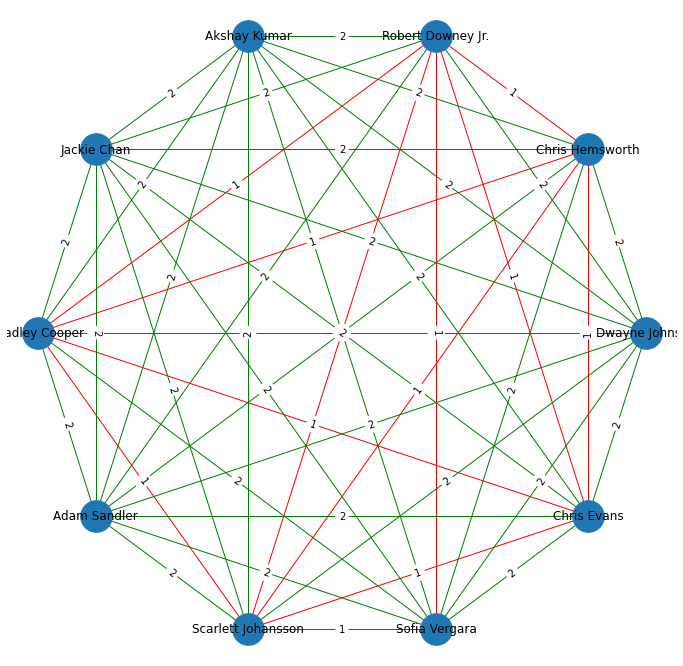

In [14]:
# Plot the whole graph
imdbh.plot_graph(distances, [])

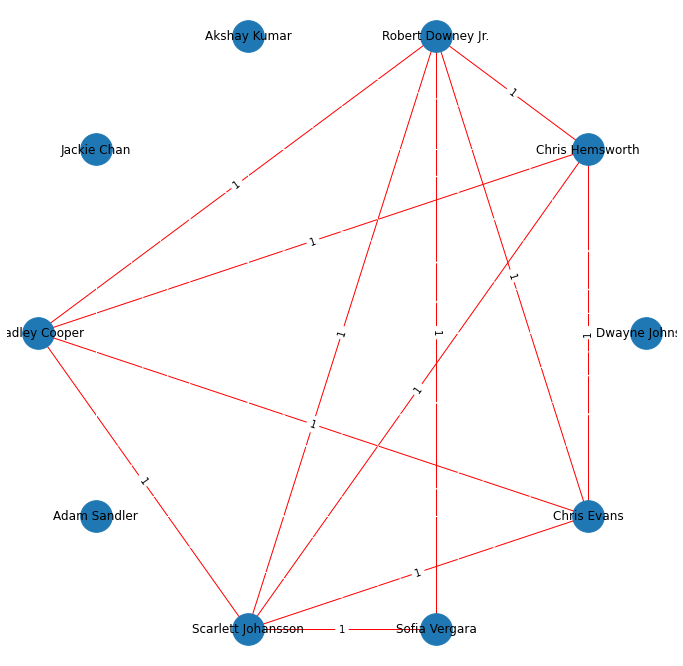

In [15]:
# Plot only vertices with weight 1
imdbh.plot_graph(distances, [1])

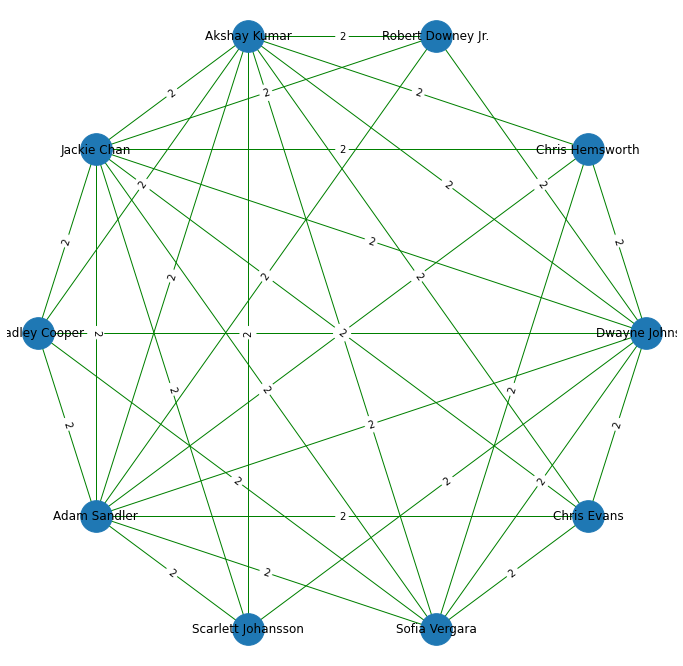

In [16]:
# Plot only vertices with weight 2
imdbh.plot_graph(distances, [2])

## Collect descriptions

Now we are going to have some fun and plot word clouds for every actor so one can guess an actor by movies descriptions cloud.

In [17]:
actors_dict.items()

dict_items([('https://www.imdb.com/name/nm0425005/', 'Dwayne Johnson'), ('https://www.imdb.com/name/nm1165110/', 'Chris Hemsworth'), ('https://www.imdb.com/name/nm0000375/', 'Robert Downey Jr.'), ('https://www.imdb.com/name/nm0474774/', 'Akshay Kumar'), ('https://www.imdb.com/name/nm0000329/', 'Jackie Chan'), ('https://www.imdb.com/name/nm0177896/', 'Bradley Cooper'), ('https://www.imdb.com/name/nm0001191/', 'Adam Sandler'), ('https://www.imdb.com/name/nm0424060/', 'Scarlett Johansson'), ('https://www.imdb.com/name/nm0005527/', 'Sofia Vergara'), ('https://www.imdb.com/name/nm0262635/', 'Chris Evans')])

In [18]:
_M_LIM = 5 # How many movies descriptions to collect for every actor.
_collect_descriptions = False # We have already created files with movie descriptions for every actor.

In [19]:
if _collect_descriptions:
    for url, name in actors_dict.items():
        # Get url soup.
        soup = imdbh.get_page_data_helper(url)

        # Find actor's movies from soup.
        movies = await imdb.get_movies_by_actor_soup(soup, num_of_movies_limit=_M_LIM)
        # Leave only movies names.
        movies = [movie.name for movie in movies]

        # Find movies' desriptions from soup.
        description = await imdb.get_movie_descriptions_by_actor_soup(soup, num_of_movies_limit=_M_LIM)

        # Save descriptions.
        result = dict(zip(movies, description))
        with open(f'{name}.json', 'w') as f:
            json.dump(result, f)

In [20]:
if not _collect_descriptions:
    # Read descriptions from files.
    descriptions = {}
    for url, name in actors_dict.items():
        with open(f'{name}.json') as f:
            result = json.load(f)
            descriptions[name] = ' '.join(result.values())

## Plot results

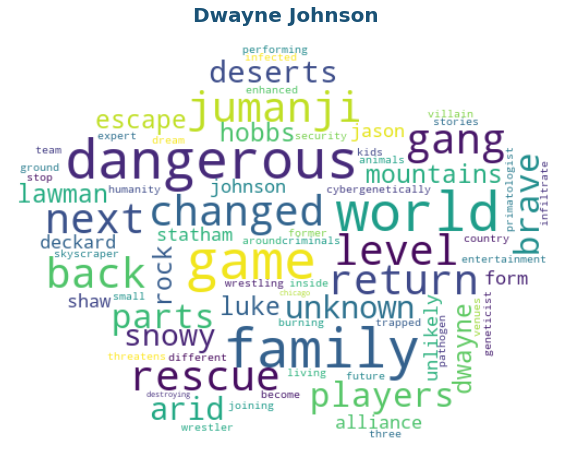

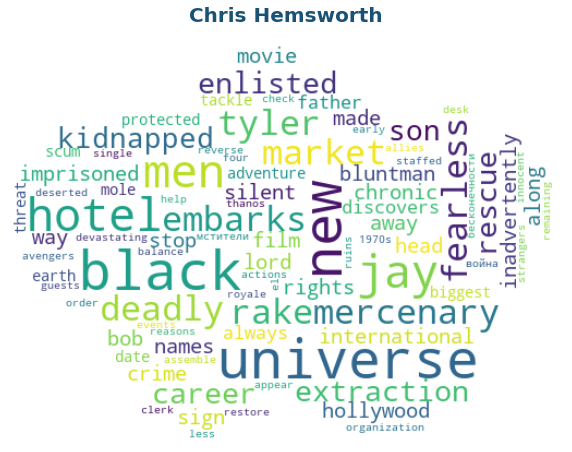

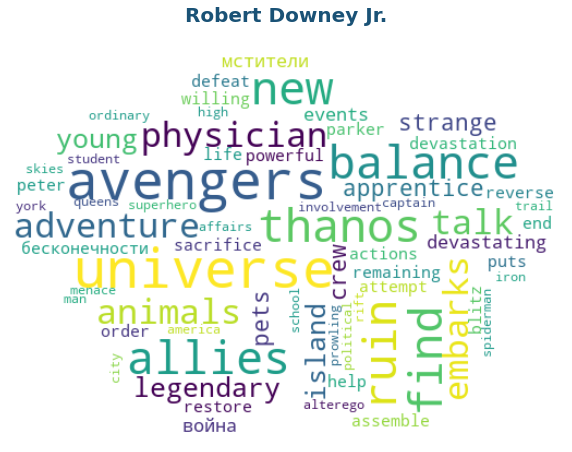

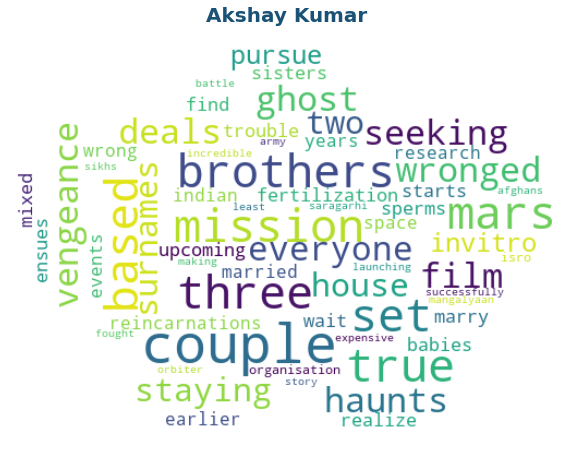

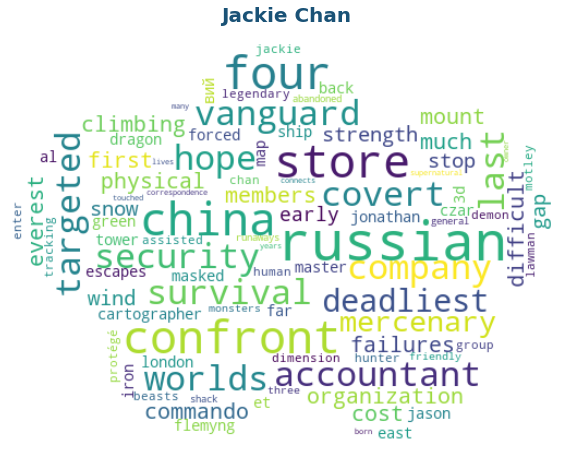

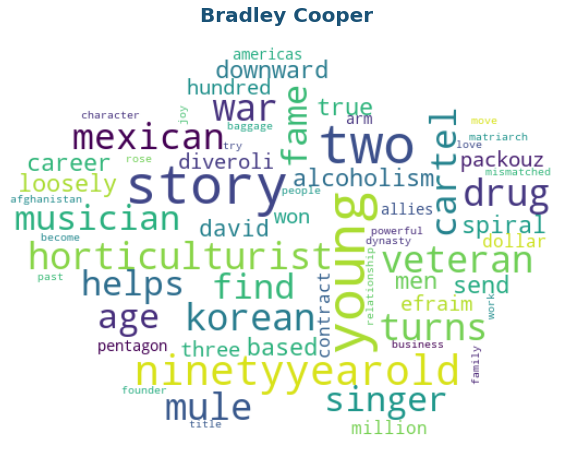

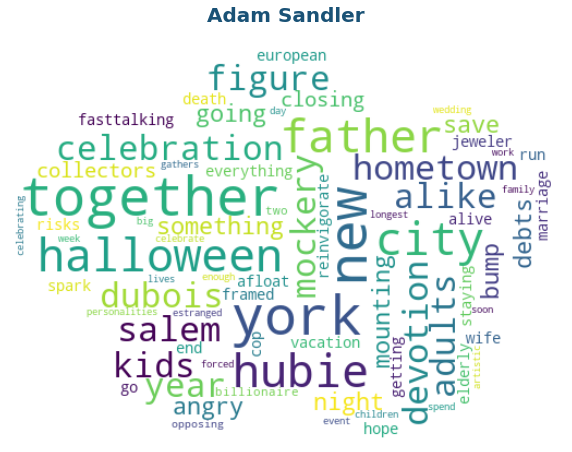

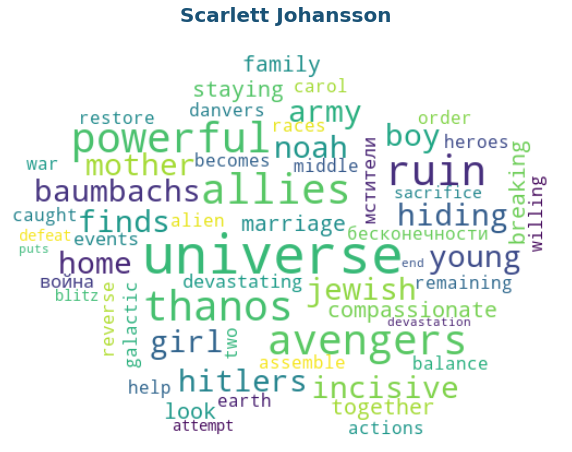

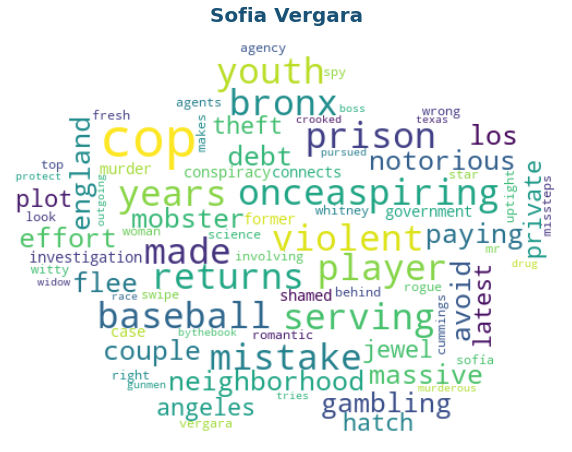

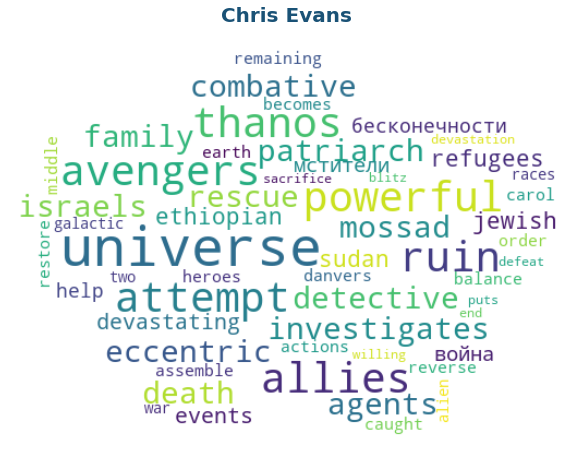

In [21]:
imdbh.plot_wordcloud(descriptions)